In [19]:
import numpy as np
import pandas as pd
import sqlite3 as sl3

#Load Data From Database

In [3]:
dbfile = "recipes.db"
conn = sl3.connect(dbfile)
cur = conn.cursor()

In [4]:
# Take a peek at the existing tables
cur.execute("SELECT name, sql FROM sqlite_master WHERE type='table'")
for table, sql in cur.fetchall():
    print table, sql

recipes CREATE TABLE recipes(
		recipe_id INTEGER, 
		search_query TEXT,
		url TEXT,
		website TEXT,
		timestamp TEXT,
		average_rating REAL,
		number_ratings INTEGER,
		yield_quantity REAL,
		yield_units TEXT,
		yield_type TEXT,
		PRIMARY KEY (recipe_id,url)
		)
ingredients CREATE TABLE ingredients(
		recipe_id INTEGER,
                ingredient_id INTEGER,
		description TEXT,
		amount REAL
		)
new_ingredients CREATE TABLE "new_ingredients" (
"index" INTEGER,
  "recipe_id" REAL,
  "description" TEXT,
  "amount" REAL,
  "new_description" TEXT,
  "proportion" REAL
)
base_ingredients CREATE TABLE "base_ingredients" (
"index" INTEGER,
  "new_description" TEXT,
  "mean_proportion" REAL,
  "stddev_proportion" REAL,
  "counts" INTEGER
)


In [5]:
# Read in 'ingredients' table
query = "SELECT new_description, mean_proportion, stddev_proportion, counts FROM base_ingredients"
ingr_df = pd.read_sql(query, conn)

# Take a look at the data:
print len(ingr_df), 'entries'
print len(ingr_df.new_description.unique()), 'distinct ingredients'
print ingr_df.sort(['counts'],ascending=[0])

129 entries
129 distinct ingredients
        new_description  mean_proportion  stddev_proportion  counts
55               garlic         0.010577           0.007612      82
54       garbonzo beans         0.598739           0.186017      76
81            olive oil         0.043827           0.046208      69
67          lemon juice         0.076270           0.056109      67
102                salt         0.004098           0.003616      58
113              tahini         0.082664           0.065108      49
42                cumin         0.003360           0.003073      37
16         black pepper         0.001551           0.002348      28
122               water         0.138366           0.181471      22
87              paprika         0.001801           0.001171      17
25       cayenne pepper         0.002782           0.003351      16
11                basil         0.014749           0.022653      15
83                onion         0.097915           0.080114      15
14         

# Plot The Data

The goal here is to look at a few features of the data to see if we can find good criteria for distinguishing ingredients into different groups. Specifically, I'm looking at the mean & standard deviation of the proportion of each ingredient in it's respective recipe and the number of occurances of each ingredient within our recipe set.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# create arrays for plotting inputs
mean = ingr_df['mean_proportion'].as_matrix()
stddev = ingr_df['stddev_proportion'].as_matrix()
counts = ingr_df['counts'].as_matrix()
samples = len(ingr_df)

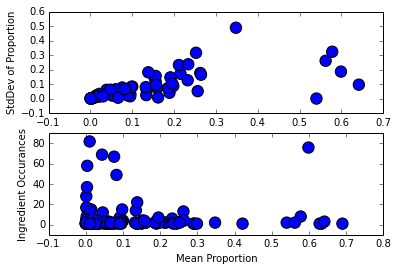

In [10]:
# first plot 2D distributions
plt.figure(1)
plt.subplot(211)
plt.scatter(mean,stddev,s=samples)
plt.ylabel('StdDev of Proportion')

plt.subplot(212)
plt.scatter(mean,counts,s=samples)
plt.ylabel('Ingredient Occurances')
plt.xlabel('Mean Proportion')

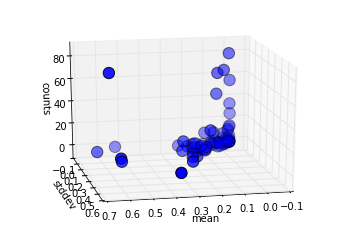

In [15]:
# Now generate interactive 3D plot with all features
from mpl_toolkits import mplot3d
from IPython.html.widgets import interact

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(mean, stddev, counts, s=samples)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('mean')
    ax.set_ylabel('stddev')
    ax.set_zlabel('counts')
    
interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

#Initial Thoughts:
I was thinking that that there might be more clear clusters of ingredients. My thinking was specifically in regard to porportion: If you think about, say, garbanzo beans and black beans in normal and black bean hummus respectively. You would expect them to have a porportion of their recipe. Nievely extrapolating this thinking, I figured you might be able to define clusters of ingredients that would result in a certain "type" of ingredient in a recipe and then use these clusters to select ingredients.

As I said though, it seems like there aren't quite as many separate distinct clusters as I expected. Especially when you look in the 3 dimensional space.

Never the less, I'll try just plugging the data in to a clustering algorithm.

#Apply Clustering to the Data
I chose the MeanShift algorithm which doesn't require a known number of clusters (but will determine this on it's own) and seems adequite for our relatively small dataset.

In [49]:
from sklearn.cluster import MeanShift, estimate_bandwidth

X = ingr_df.as_matrix(['mean_proportion','stddev_proportion','counts'])
# turn all Nan's in to 0 (there are some in the stddev column)
X[np.invert(np.isfinite(X))] = 0

# automatically calculate bandwith for input to meanshift model
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=samples)

# create and run model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# get results
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)


In [51]:
# Print meanshift results
print("number of estimated labels : %d" % n_clusters_)

for i in range(n_clusters_):
    print 'Label %d was assigned to %d ingredients and has center:'%(i,len(labels[labels==i]))
    print '   mean:%f stddev:%f count:%f'%(cluster_centers[i,0],cluster_centers[i,1],cluster_centers[i,2])
    print '   It includes the following ingredients:'
    for index in np.where(labels==i)[0]:
        print '      %d %s'%(ingr_df['counts'][index],ingr_df['new_description'][index])
    print

number of estimated labels : 9
Label 0 was assigned to 112 ingredients and has center:
   mean:0.115295 stddev:0.035751 count:1.859813
   It includes the following ingredients:
      4 Italian dressing
      2 allspice
      1 apple sauce
      2 apples
      3 artichoke hearts
      1 arugula
      3 avocado
      1 bacon
      1 baking soda
      3 balsamic vinegar
      2 banana peppers
      1 bay leaf
      1 beets
      8 black beans
      6 bread
      1 broccoli
      1 broth
      1 brown sugar
      1 butter
      1 cabbage
      2 canola oil
      1 cashews
      1 celery seed
      1 cheddar cheese
      2 chicken breast
      2 chili powder
      1 chipotle pepper
      8 cilantro
      2 cinnamon
      1 coconut
      1 cocounut oil
      1 coleslaw
      3 coriander
      2 corn
      2 cottage cheese
      2 cream cheese
      2 crushed red pepper
      4 cucumber
      1 curry paste
      3 curry powder
      1 dijon mustard
      1 dill
      1 egg
      1 eggplant
  

#Conclusion:
The clusters were not quite what I expected, but they seem compelling none the less. It seems that the resulting clusters were mostly driven by what I deem the most common and important ingredients. But the lower label numbers are interesting. It seems that label 0 clustered the most exotic and least used ingredients. And label 1 has some borderline ingredients: things that are solid optional ingredients (possibly good for making some recipe variants?). Then as far as I can tell labels 2-8 are essential core ingredients.

So while I expected to cluster similar types of ingredients, then choose the top "best" or most common ingredients from each type, instead the clusters seem to have effectively done the ingredient choosing for us. As described, I think a reasonable first pass for chosing ingredients would be to use labels 2-8 as an ingredient base and use label 1 for optional variants then discard label 0 ingredients.

#To Do:
I would still like to try a few variations of the clustering input. Instead of the 3 dimensions used as input, I'd like to compare the results using only mean_proportion and counts

Also, I didn't push any of these results to the database or any separate file yet. Still have to do that.